# Covid case forecasting Using TimeSeriesModel from arcgis.learn

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Importing libraries](#2)
* [Connecting to your GIS](#3)
* [Accessing the dataset](#4) 
* [Raw data cleaning](#5) 
    * [Calculate Moving Average for Confirmed cases](#6)
    * [Cut off first 6 days date](#7) 
* [Time series data preprocessing](#8) 
    * [Collecting the counties of the Alabama State](#9) 
* [Time series modeling and forecasting](#10) 
* [Result visualization](#11) 
* [Conclusion](#12)

## Introduction<a class="anchor" id="1"></a> 

COVID-19 forecasting has been vital for efficiently planning health care policy during the pandemic. There are many forecasting models, a few of which require explanatory variables like population, social distancing, etc. This notebook uses the deep learning `TimeSeriesModel` from `arcgis.learn` for data modeling and is helpful in the prediction of future trends.

To demonstrate the utility of this method, this notebook will analyze confirmed cases for all counties in Alabama. The dataset contains the unique county FIPS ID, county Name, State ID, and cumulative confirmed cases datewise for each county. The dataset ranges from January 2020 to February 2022, with the data from January 2022 to February 2022 being used to validate the quality of the forecast. The approach utilized in this analysis for forecasting future COVID-19 cases involves: (a) Data Processing (calculating the seven day moving average for removing the noise and vertically stacking the county data), (b) creating functions for test-train splitting, tabular data preparation, model fitting using Inception Time for a sequence length of 60, and forecasting, and (c) validation and visualization of the predicted data and results.



## Importing Libraries<a class="anchor" id="2"></a> 

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata

## Connecting to your GIS<a class="anchor" id="3"></a> 

In [3]:
gis = GIS("home")

## Accessing the dataset <a class="anchor" id="4"></a>
The latest dataset can be downloaded from USAFacts: 
https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

<Item title:"USA Covid Confirmed Cases Dataset" type:CSV owner:api_data_owner>
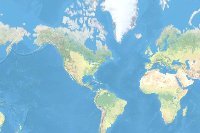

In [3]:
# Access the data table
data_table = gis.content.get("b222748b885e4741839f3787f207b2b1")
data_table

In [4]:
# Download the csv and saving it in local folder
data_path = data_table.get_data()

In [5]:
# # Read the csv file
confirmed = pd.read_csv(data_path)
confirmed.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2022-01-23,2022-01-24,2022-01-25,2022-01-26,2022-01-27,2022-01-28,2022-01-29,2022-01-30,2022-01-31,2022-02-01
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,13019,13251,13251,13251,13251,13251,13251,13251,13251,14826
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,49168,50313,50313,50313,50313,50313,50313,50313,50313,53083
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,4902,5054,5054,5054,5054,5054,5054,5054,5054,5297
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,5663,5795,5795,5795,5795,5795,5795,5795,5795,6158


## Raw data cleaning<a class="anchor" id="5"></a>   

In [6]:
# Extract the data of Alabama State
confirmed_AL = confirmed.loc[
    (confirmed["countyFIPS"] >= 1000) & (confirmed["countyFIPS"] <= 1133)]

In [7]:
# Stack the table for cumulative confirmed cases
confirmed_AL = confirmed_AL.set_index(["countyFIPS"])
confirmed_AL = confirmed_AL.drop(columns=["State", "County Name", "StateFIPS"])
confirmed_stacked_df = (
    confirmed_AL.stack()
    .reset_index()
    .rename(columns={"level_1": "OriginalDate", 0: "ConfirmedCases"})
)
confirmed_stacked_df

,countyFIPS,OriginalDate,ConfirmedCases
0,1001,2020-01-22,0
1,1001,2020-01-23,0
2,1001,2020-01-24,0
3,1001,2020-01-25,0
4,1001,2020-01-26,0
...,...,...,...
49709,1133,2022-01-28,6323
49710,1133,2022-01-29,6323
49711,1133,2022-01-30,6323
49712,1133,2022-01-31,6323


In [8]:
# Converting into date time field format
confirmed_stacked_df["DateTime"] = pd.to_datetime(
    confirmed_stacked_df["OriginalDate"], infer_datetime_format=True
)
confirmed_stacked_df = confirmed_stacked_df.drop(columns=["OriginalDate"])
confirmed_stacked_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49714 entries, 0 to 49713
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   countyFIPS      49714 non-null  int64         
 1   ConfirmedCases  49714 non-null  int64         
 2   DateTime        49714 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


### Calculate Moving Average for Confirmed cases<a class="anchor" id="6"></a> 
Here, we calculate a 7-day simple moving average to smooth out the data and remove noise caused by spikes in testing results.

In [9]:
# Set moving average window = 7 days
SMA_Window = 7
# Copy the dataframe and set columns need to be calculated
df = confirmed_stacked_df
cols = {1: "ConfirmedCases"}

In [10]:
SMA_Window = 7
for fips in df.countyFIPS.unique():
    for col in cols:
        field = f"{cols[col]}_SMA{SMA_Window}"
        df.loc[df["countyFIPS"] == fips, field] = (
            df.loc[df["countyFIPS"] == fips]
            .iloc[:, col]
            .rolling(window=SMA_Window)
            .mean()
        )

### Cut off first 6 day's date<a class="anchor" id="7"></a> 
As the first moving average value starts from the seventh day, we will disregard the first 6 days.

In [11]:
firstMADay = df["DateTime"].iloc[0] + pd.DateOffset(days=SMA_Window - 1)
firstMADay

Timestamp('2020-01-28 00:00:00')

In [12]:
df_FirstMADay = df.loc[df["DateTime"] >= firstMADay]
df_FirstMADay.reset_index(drop=True, inplace=True)
df_FirstMADay

,countyFIPS,ConfirmedCases,DateTime,ConfirmedCases_SMA7
0,1001,0,2020-01-28,0.000000
1,1001,0,2020-01-29,0.000000
2,1001,0,2020-01-30,0.000000
3,1001,0,2020-01-31,0.000000
4,1001,0,2020-02-01,0.000000
...,...,...,...,...
49307,1133,6323,2022-01-28,6248.714286
49308,1133,6323,2022-01-29,6285.857143
49309,1133,6323,2022-01-30,6323.000000
49310,1133,6323,2022-01-31,6323.000000


## Time series data preprocessing<a class="anchor" id="8"></a>   
The preprocessing of the data for multivariate time series modeling includes the selection of required columns, converting time into the date-time format, and collecting all the counties of the state.

In [13]:
# Selecting the required columns for modeling
df = df_FirstMADay[["DateTime", "ConfirmedCases_SMA7", "countyFIPS"]].copy()
df.columns = ["date", "cases", "countyFIPS"]
df.date = pd.to_datetime(df.date, format="%Y-%m-%d")

In [14]:
df.tail()

,date,cases,countyFIPS
49307,2022-01-28,6248.714286,1133
49308,2022-01-29,6285.857143,1133
49309,2022-01-30,6323.000000,1133
49310,2022-01-31,6323.000000,1133
49311,2022-02-01,6427.857143,1133


### Collecting the counties of Alabama<a class="anchor" id="9"></a>   

In [15]:
# This cell collects all counties by their Unique FIPS IDs.
counties = df.countyFIPS.unique()
counties = [county for county in counties if county != 0]
len(counties)

67

The next cell can be used to forecast for a specific county. You can declare the county to forecast by using its FIPS ID.

In [16]:
# counties = df.countyFIPS.unique()
# counties = [county for county in counties if county == 1001]

## Time series modeling and forecasting<a class="anchor" id="10"></a>  
Here, we will create the different functions for preparing tabular data, modeling, and forecasting that will later be called for each county.

In [17]:
# This function selects the specified county data and splits the train and test data
def CountyData(county, test_size):
    data_file = df[df["countyFIPS"] == county]
    data_file.reset_index(inplace=True, drop=True)
    train, test = train_test_split(data_file, test_size=test_size, shuffle=False)
    return train, test

The next function prepares the tabular data and initializes the model from the available set of backbones (InceptionTime, ResCNN, Resnet, and FCN). The sequence length here is provided as 15, which was found by performing a grid search. To train the model, the `model.fit` method is used and is provided with the number of training epochs and the learning rate.

In [18]:
def Model(train, seq_len, test_size):
    data = prepare_tabulardata(
        train, variable_predict="cases", index_field="date", seed=42
    )  # Preparing the tabular data
    tsmodel = TimeSeriesModel(
        data, seq_len=seq_len, model_arch="InceptionTime"
    )  # Model initialization
    lr_rate = tsmodel.lr_find()  # Finding the Learning rate
    tsmodel.fit(100, lr=lr_rate, checkpoint=False)  # Model training
    sdf_forecasted = tsmodel.predict(
        train, prediction_type="dataframe", number_of_predictions=test_size
    )  # Forecasting using the trained TimeSeriesModel
    return sdf_forecasted

In [19]:
# This function evalutes the model metrics and returns the dictionary
def evaluate(test, sdf_forecasted):
    r2_test = r2_score(test["cases"], sdf_forecasted["cases_results"][-14:])
    mse = metrics.mean_squared_error(
        test["cases"], sdf_forecasted["cases_results"][-14:]
    )
    mae = metrics.mean_absolute_error(
        test["cases"], sdf_forecasted["cases_results"][-14:]
    )
    return {
        "DATE": test["date"],
        "cases_actual": test["cases"],
        "cases_predicted": sdf_forecasted["cases_results"][-14:],
        "R-square": round(r2_test, 2),
        "V_RMSE": round(np.sqrt(mse), 4),
        "MAE": round(mae, 4),
    }

In [20]:
# This class calls all the defined functions
class CovidModel(object):
    seq_len = 15
    test_size = 14

    def __init__(self, county):
        self.county = county

    def CountyData(self):
        self.train, self.test = CountyData(self.county, self.test_size)

    def Model(self):
        self.sdf_forecasted = Model(self.train, self.seq_len, self.test_size)

    def evaluate(self):
        return evaluate(self.test, self.sdf_forecasted)

Training the model for all counties and saving the metrics in the dictionary.

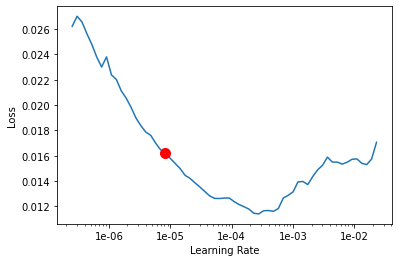

epoch,train_loss,valid_loss,time
0,0.022296,0.072083,00:00
1,0.021528,0.056567,00:00
2,0.019676,0.056948,00:00
3,0.017958,0.063523,00:00
4,0.016059,0.051571,00:00
5,0.014255,0.022249,00:00
6,0.012279,0.007439,00:00
7,0.010936,0.004679,00:00
8,0.010135,0.003242,00:00
9,0.008722,0.002114,00:00


In [21]:
dct = {}

for i, county in enumerate(counties):
    covidmodel = CovidModel(county)
    covidmodel.CountyData()
    covidmodel.Model()
    dct[county] = covidmodel.evaluate()

## Result Visualization<a class="anchor" id="11"></a>  
Finally, the actual and forecasted values are plotted to visualize their distribution over the validation period, with the orange line representing the forecasted values and the blue line representing the actual values.

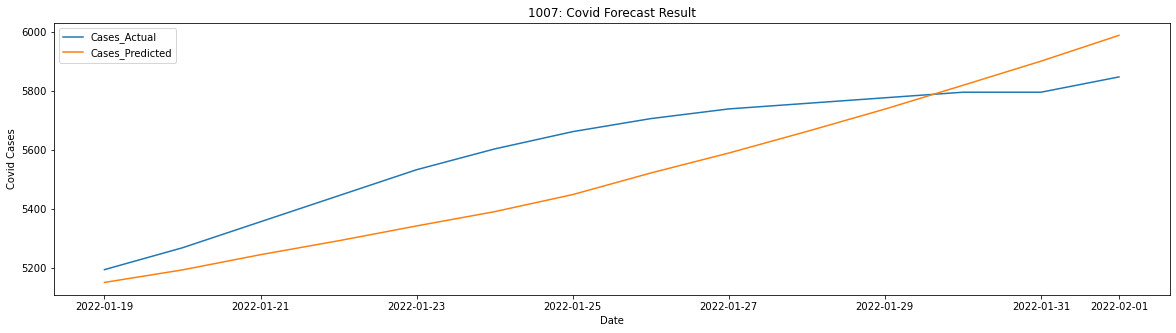

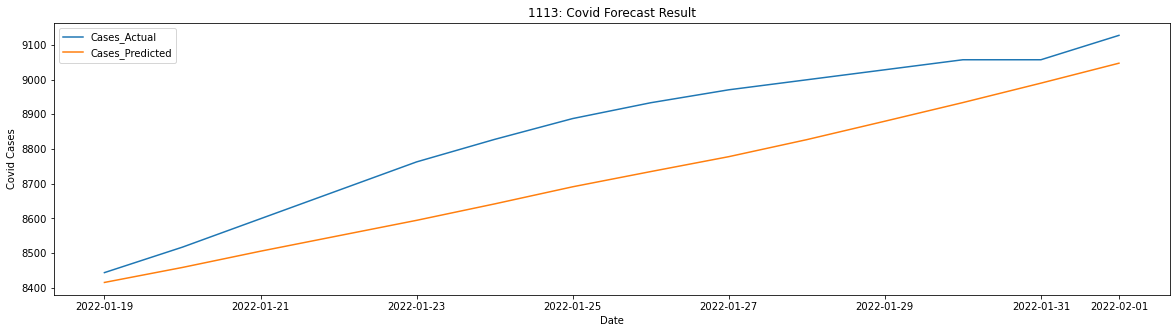

In [22]:
# Specifying few counties for visualizing the results
viz_counties = [1007,1113]

for i, county in enumerate(viz_counties):
    result_df = pd.DataFrame(dct[county])
    plt.figure(figsize=(20, 5))
    plt.plot(result_df["DATE"], result_df[["cases_actual", "cases_predicted"]])
    plt.xlabel("Date")
    plt.ylabel("Covid Cases")
    plt.legend(["Cases_Actual", "Cases_Predicted"], loc="upper left")
    plt.title(str(county) + ": Covid Forecast Result")
    plt.show()

In [23]:
# Here the Alabama counties feature layer is accessed and converted to spatial dataframe
item = gis.content.get("41e8eb46285d4e1f85ee6e826b05e077")
flayer = item.layers[0]
f_sdf = flayer.query().sdf

In [24]:
# Adding the RMSE and MAE from the output dictionary to the spatial dataframe
RMSE = []
MAE = []
for i, county in enumerate(counties):
    MAE.append(dct[county]["MAE"])
    RMSE.append(dct[county]["V_RMSE"])

f_sdf = f_sdf.assign(RMSE=RMSE, MAE=MAE)

Next, we will publish this spatial dataframe as a feature layer.

<Item title:"Alabama Covid Time Series Model Metrics" type:Feature Layer Collection owner:api_data_owner>
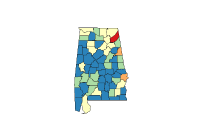

In [25]:
published_sdf = gis.content.import_data(f_sdf, title='Alabama Covid Time Series Model Metrics')
published_sdf

Next, we will open the published web layer and input the item id of the published output layer.


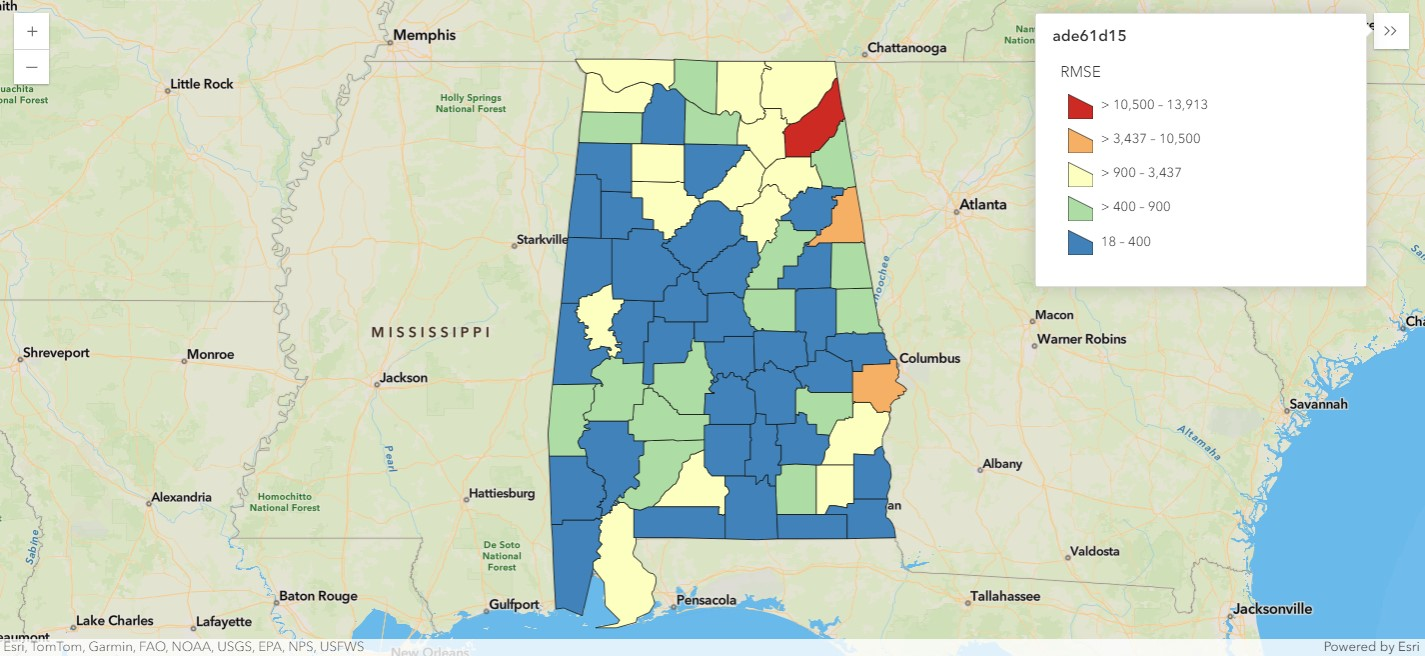

In [5]:
item = gis.content.get("9d197a4870a1479c81ddfd6b739816da")
map1 = gis.map("Alabama")
map1.content.add(item)
map1.legend.enabled = True
map1

From the map, it can be seen that most of the counties have RMSE ranging from 18-400 cases, represented by the blue polygons. The fewer green and cream colored counties have higher RMSE, and the one red county has the maximum RMSE. This indicates that `InceptionTime` is performing well for this state, and that other backbones can be introduced to further reduce the RMSE in the counties that have higher RMSE.

## Conclusion<a class="anchor" id="12"></a>

This study conducted a univariate time series analysis using the Deep learning `TimeSeriesModel` from the `arcgis.learn` library and forecasted the COVID-19 confirmed cases for the counties in Alabama. The initial raw data was averaged over 7 days using the seven-day moving average method to avoid sudden spikes. The methodology also included preparing a time series dataset using the `prepare_tabulardata()` method, followed by modeling, predicting, and validating the test dataset. The TimeSeriesModel from `arcgis.learn` includes backbones, such as `InceptionTime`, `ResCNN`, `ResNet`, and `FCN`, that do not need fine-tuning of multiple hyperparameters before fitting the model. Our method produced reasonably accurate results, and users can change the sequence length or backbone for forecasting in other areas.